In [2]:
print("hlo")

hlo


To turn on GPU in Google Colab, follow these steps:

1.  **Click on `Runtime`** in the top menu bar.
2.  **Select `Change runtime type`** from the dropdown menu.
3.  In the "Notebook settings" dialog box, **find the "Hardware accelerator" dropdown**.
4.  **Choose `GPU`** (or `TPU` if you prefer) from the options.
5.  **Click `Save`**.

Your notebook will then restart, and you will have access to a GPU runtime.

In [3]:
# CELL 1 — Imports and device setup

import os
import random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import matplotlib.pyplot as plt

# Show plots inside notebook
%matplotlib inline

# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# CELL 2 — Clone Oxford Pets dataset from GitHub repo you shared

!git clone https://github.com/ml4py/dataset-iiit-pet.git /content/pets

# Check folders exist
import os

DATA_ROOT = "/content/pets"
print("Root contents:", os.listdir(DATA_ROOT))

# Important folders must exist:
# /content/pets/images
# /content/pets/annotations/trimaps

print("Images dir exists:", os.path.isdir(os.path.join(DATA_ROOT, "images")))
print("Annotations dir exists:", os.path.isdir(os.path.join(DATA_ROOT, "annotations")))
print("Trimaps dir exists:", os.path.isdir(os.path.join(DATA_ROOT, "annotations", "trimaps")))


Cloning into '/content/pets'...
remote: Enumerating objects: 18465, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 18465 (delta 1), reused 3 (delta 1), pack-reused 18460 (from 1)
Receiving objects: 100% (18465/18465), 772.55 MiB | 16.32 MiB/s, done.
Resolving deltas: 100% (3678/3678), done.
Updating files: 100% (18477/18477), done.
Root contents: ['annotations', '.gitignore', 'README.md', 'images', '.git']
Images dir exists: True
Annotations dir exists: True
Trimaps dir exists: True


In [5]:
# CELL 3 — Build file ID list + Train/Val Split

import os, random

DATA_ROOT = "/content/pets"
IMAGES_DIR = os.path.join(DATA_ROOT, "images")
TRIMAPS_DIR = os.path.join(DATA_ROOT, "annotations", "trimaps")

# list all .jpg images
all_image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(".jpg")]
all_image_files.sort()

print("Total images found:", len(all_image_files))
print("Sample:", all_image_files[:5])

# create ID list without extension
all_ids = [os.path.splitext(f)[0] for f in all_image_files]

# shuffle for randomness
random.seed(42)
random.shuffle(all_ids)

# split: 80% train / 20% val
train_ratio = 0.8
train_count = int(len(all_ids) * train_ratio)

train_ids = all_ids[:train_count]
val_ids = all_ids[train_count:]

print("Train samples:", len(train_ids))
print("Val samples:", len(val_ids))


Total images found: 7390
Sample: ['Abyssinian_1.jpg', 'Abyssinian_10.jpg', 'Abyssinian_100.jpg', 'Abyssinian_101.jpg', 'Abyssinian_102.jpg']
Train samples: 5912
Val samples: 1478


In [6]:
# CELL 4 — PetsSegmentationDataset: loads (image, mask) pairs

class PetsSegmentationDataset(Dataset):
    """
    Oxford-IIIT Pet segmentation dataset (simplified):
    - Image: RGB JPG from images/
    - Mask:  PNG trimap from annotations/trimaps/

    Trimap values are:
      1 = background
      2 = pet
      3 = outline

    We'll convert this to a simple binary mask:
      0 = background  (trimap == 1)
      1 = pet (trimap == 2 or 3)

    So num_classes = 2 for now.
    """
    def __init__(self, ids, images_dir, trimaps_dir, image_size=256, augment=False):
        self.ids = ids
        self.images_dir = images_dir
        self.trimaps_dir = trimaps_dir
        self.image_size = image_size
        self.augment = augment

        # Image transform: resize + convert to tensor [0,1]
        self.img_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),   # [C,H,W] in [0,1]
        ])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]

        # Build file paths
        img_path = os.path.join(self.images_dir, img_id + ".jpg")
        mask_path = os.path.join(self.trimaps_dir, img_id + ".png")

        # Load RGB image
        image = Image.open(img_path).convert("RGB")

        # Load mask (single channel)
        mask = Image.open(mask_path)

        # Apply same resize to both
        image = self.img_transform(image)

        # Resize mask with NEAREST (so class ids don't get interpolated)
        mask = mask.resize((self.image_size, self.image_size), resample=Image.NEAREST)
        mask = np.array(mask)

        # Convert trimap (1,2,3) -> binary (0,1)
        # 1 -> 0 (background), 2/3 -> 1 (pet)
        mask = np.where(mask == 1, 0, 1).astype(np.uint8)

        # Convert to tensor, long dtype for CrossEntropyLoss
        mask = torch.from_numpy(mask).long()   # [H, W]

        # Simple random horizontal flip as augmentation (only if enabled)
        if self.augment:
            if random.random() < 0.5:
                image = torch.flip(image, dims=[2])  # flip width dimension
                mask = torch.flip(mask, dims=[1])

        return image, mask


In [7]:
# CELL 5 — UNet model for binary segmentation (background vs pet)

class DoubleConv(nn.Module):
    """(Conv → BN → ReLU) × 2"""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Encoder
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        # Final per‑pixel class scores
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.down1(x)
        p1 = self.pool1(c1)

        c2 = self.down2(p1)
        p2 = self.pool2(c2)

        c3 = self.down3(p2)
        p3 = self.pool3(c3)

        c4 = self.down4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        bn = self.bottleneck(p4)

        # Decoder with skip connections
        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        c4 = self.conv4(u4)

        u3 = self.up3(c4)
        u3 = torch.cat([u3, c3], dim=1)
        c3 = self.conv3(u3)

        u2 = self.up2(c3)
        u2 = torch.cat([u2, c2], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        u1 = torch.cat([u1, c1], dim=1)
        c1 = self.conv1(u1)

        logits = self.out_conv(c1)   # shape: [B, n_classes, H, W]
        return logits


In [8]:
# CELL 6 — IoU metric function

def compute_iou(pred, target, num_classes=2, eps=1e-6):
    """
    pred:   [N, H, W] tensor (class indices)
    target: [N, H, W] tensor (class indices)

    Returns mean IoU over all classes present.
    """
    ious = []
    for cls in range(num_classes):
        # Boolean masks: pixels predicted as this class / actual this class
        pred_c = (pred == cls)
        target_c = (target == cls)

        # Intersection = pixels where both are this class
        intersection = (pred_c & target_c).sum().float()
        # Union = pixels where either pred or target is this class
        union = (pred_c | target_c).sum().float()

        if union == 0:
            # class not present in this batch → skip
            continue

        iou = (intersection + eps) / (union + eps)
        ious.append(iou)

    if len(ious) == 0:
        return torch.tensor(0.0)
    return torch.mean(torch.stack(ious))


In [9]:
# CELL 7 — Create DataLoaders (train & val) and basic config

from torch.utils.data import DataLoader

# Basic config
IMAGE_SIZE = 256       # resize all images to 256x256
BATCH_SIZE = 4         # you can change later
NUM_CLASSES = 2        # background vs pet
LR = 1e-3              # learning rate
NUM_EPOCHS = 5         # for practice; increase later if you want

# Create Dataset objects
train_dataset = PetsSegmentationDataset(
    ids=train_ids,
    images_dir=IMAGES_DIR,
    trimaps_dir=TRIMAPS_DIR,
    image_size=IMAGE_SIZE,
    augment=True,      # training pe augmentation ON
)

val_dataset = PetsSegmentationDataset(
    ids=val_ids,
    images_dir=IMAGES_DIR,
    trimaps_dir=TRIMAPS_DIR,
    image_size=IMAGE_SIZE,
    augment=False,     # validation pe augmentation OFF
)

# Wrap them in DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 1478
Val batches: 370


In [10]:
# CELL 8 — Training & validation loops + main training

# Create model, loss, optimizer
model = UNet(n_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()                 # good for segmentation with class IDs
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


def train_one_epoch(model, loader, optimizer, criterion, num_classes=NUM_CLASSES):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    count = 0

    for images, masks in loader:
        images = images.to(device)        # [B,3,H,W]
        masks = masks.to(device)          # [B,H,W]

        optimizer.zero_grad()
        outputs = model(images)           # [B,C,H,W]
        loss = criterion(outputs, masks)  # CE: logits + class indices
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        with torch.no_grad():
            preds = outputs.argmax(dim=1)  # [B,H,W]
            iou = compute_iou(preds, masks, num_classes=num_classes)
            total_iou += iou.item()

        count += 1

    return total_loss / count, total_iou / count


def validate(model, loader, criterion, num_classes=NUM_CLASSES):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    count = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            iou = compute_iou(preds, masks, num_classes=num_classes)
            total_iou += iou.item()
            count += 1

    return total_loss / count, total_iou / count


# ---------- MAIN TRAINING LOOP ----------
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_iou = validate(model, val_loader, criterion)

    print(
        f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}"
    )

# Save the trained model
torch.save(model.state_dict(), "unet_pets_binary.pth")
print("Saved model to unet_pets_binary.pth")


Model parameters: 31.04M
Epoch 01/5 | Train Loss: 0.4612 | Train IoU: 0.5838 | Val Loss: 0.4430 | Val IoU: 0.5828
Epoch 02/5 | Train Loss: 0.4047 | Train IoU: 0.6421 | Val Loss: 0.3668 | Val IoU: 0.6744
Epoch 03/5 | Train Loss: 0.3468 | Train IoU: 0.6961 | Val Loss: 0.3179 | Val IoU: 0.7223
Epoch 04/5 | Train Loss: 0.3085 | Train IoU: 0.7282 | Val Loss: 0.2671 | Val IoU: 0.7588
Epoch 05/5 | Train Loss: 0.2837 | Train IoU: 0.7513 | Val Loss: 0.2630 | Val IoU: 0.7568
Saved model to unet_pets_binary.pth


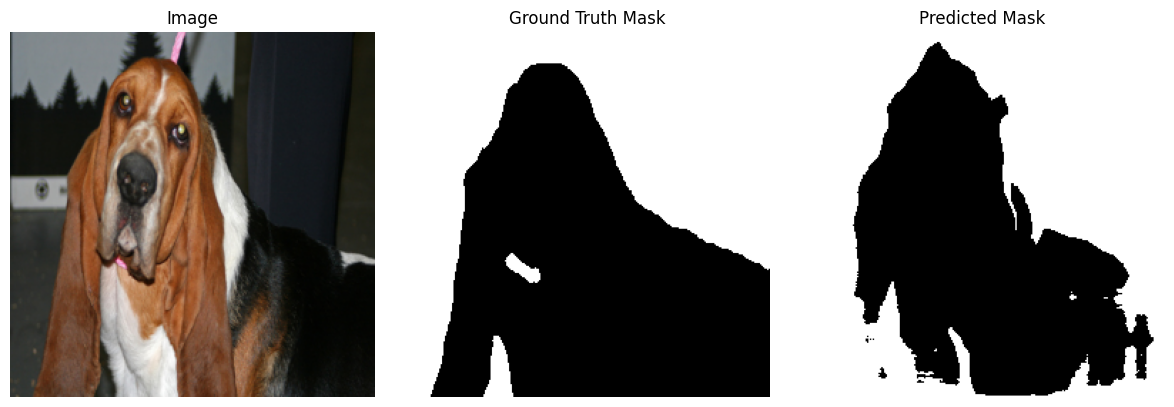

In [11]:
# CELL 9 — Visualize a sample prediction (image + GT mask + predicted mask)

def show_sample_prediction(model, dataset, index=0):
    model.eval()

    # Get one sample from dataset
    image, mask = dataset[index]      # image: [C,H,W], mask: [H,W]

    with torch.no_grad():
        x = image.unsqueeze(0).to(device)   # [1,C,H,W]
        out = model(x)                      # [1,2,H,W]
        pred = out.argmax(dim=1).squeeze(0).cpu().numpy()   # [H,W]

    img_np = image.permute(1, 2, 0).cpu().numpy()  # [H,W,C] for plotting
    gt_np = mask.cpu().numpy()                     # [H,W]

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt_np, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example: show prediction on a validation sample
show_sample_prediction(model, val_dataset, index=0)
